In [1]:
import numpy as np
#import sys
#np.set_printoptions(threshold=sys.maxsize)  #stop truncation of output
import numexpr   #(speeds up numpy + pandas)

import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib import pyplot
import seaborn as sns
import plotly

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

import pmdarima as pm
from statsmodels.tsa.arima_model import ARMA
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX

import statsmodels as sm
from scipy import stats

from scipy.stats import norm
from sklearn.metrics import mean_squared_error 

from sklearn.model_selection import TimeSeriesSplit

from fbprophet import Prophet

from datetime import datetime
from pytz import timezone
import pytz

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

Importing plotly failed. Interactive plots will not work.


In [2]:
df = pd.read_excel('BAYSHOR2_df - combined4.xlsm')
print(len(df))
df.head()

28464


,Date_time,Dollars_per_mwh,Temperature,Precipitation,Wind Speed,Cloud Cover,Conditions
0,2017-03-26 00:00:00,9.75524,53.4,0.0,8.5,38.8,Partially cloudy
1,2017-03-26 01:00:00,5.19205,53.9,0.0,7.9,56.5,Partially cloudy
2,2017-03-26 02:00:00,4.14945,53.9,0.0,4.9,61.0,Partially cloudy
3,2017-03-26 03:00:00,7.98666,53.4,0.0,6.2,56.5,Partially cloudy
4,2017-03-26 04:00:00,8.66210,52.9,0.0,6.3,56.5,Partially cloudy


In [3]:
categories = np.array(df['Conditions'])                #converting 'Conditions' column to np.array 
print(categories)
label_encoder = LabelEncoder()                        #transforming np.array to integers with LabelEncoder
categories_encoded = label_encoder.fit_transform(categories)
print(categories_encoded)
len(categories)

['Partially cloudy' 'Partially cloudy' 'Partially cloudy' ... 'Clear'
 'Clear' 'Clear']
[2 2 2 ... 0 0 0]


28464

In [4]:
df['Conditions'].value_counts()

Clear               17847
Partially cloudy     6305
Overcast             4235
Rain                   77
Name: Conditions, dtype: int64

In [5]:
onehot_encoder = OneHotEncoder(drop='first', sparse=False)                  #OneHotEncoding integers
integer_encoded = categories_encoded.reshape(len(categories_encoded), 1)
onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
print(onehot_encoded)

[[0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 ...
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]


In [6]:
df2 = pd.DataFrame(onehot_encoded, columns=onehot_encoder.get_feature_names())
df2.columns = ['Overcast', 'Partially cloudy', 'Rain']
df2.head()                                        #creating a DataFrame with OneHotEncoded integers

,Overcast,Partially cloudy,Rain
0,0.0,1.0,0.0
1,0.0,1.0,0.0
2,0.0,1.0,0.0
3,0.0,1.0,0.0
4,0.0,1.0,0.0


In [7]:
df3 = pd.concat([df,df2], axis=1)                       #Concatenating new DataFrame with original
df3.drop('Conditions', axis=1, inplace=True)           #dropping "Conditions" column after OneHotEncoding
df3['Date_time'] = pd.to_datetime(df3['Date_time'])    #setting column "Date_time" to Pandas Datetime
df3.set_index('Date_time', inplace=True)               #setting the index as "Date_time"
df3.head()

,Dollars_per_mwh,Temperature,Precipitation,Wind Speed,Cloud Cover,Overcast,Partially cloudy,Rain
Date_time,,,,,,,,
2017-03-26 00:00:00,9.75524,53.4,0.0,8.5,38.8,0.0,1.0,0.0
2017-03-26 01:00:00,5.19205,53.9,0.0,7.9,56.5,0.0,1.0,0.0
2017-03-26 02:00:00,4.14945,53.9,0.0,4.9,61.0,0.0,1.0,0.0
2017-03-26 03:00:00,7.98666,53.4,0.0,6.2,56.5,0.0,1.0,0.0
2017-03-26 04:00:00,8.66210,52.9,0.0,6.3,56.5,0.0,1.0,0.0


In [8]:
## df3 = pd.DataFrame.sparse.from_spmatrix(x)  ## another way to create the dataframe

In [9]:
df3.isnull().sum()    #No missing values

Dollars_per_mwh     0
Temperature         0
Precipitation       0
Wind Speed          0
Cloud Cover         0
Overcast            0
Partially cloudy    0
Rain                0
dtype: int64

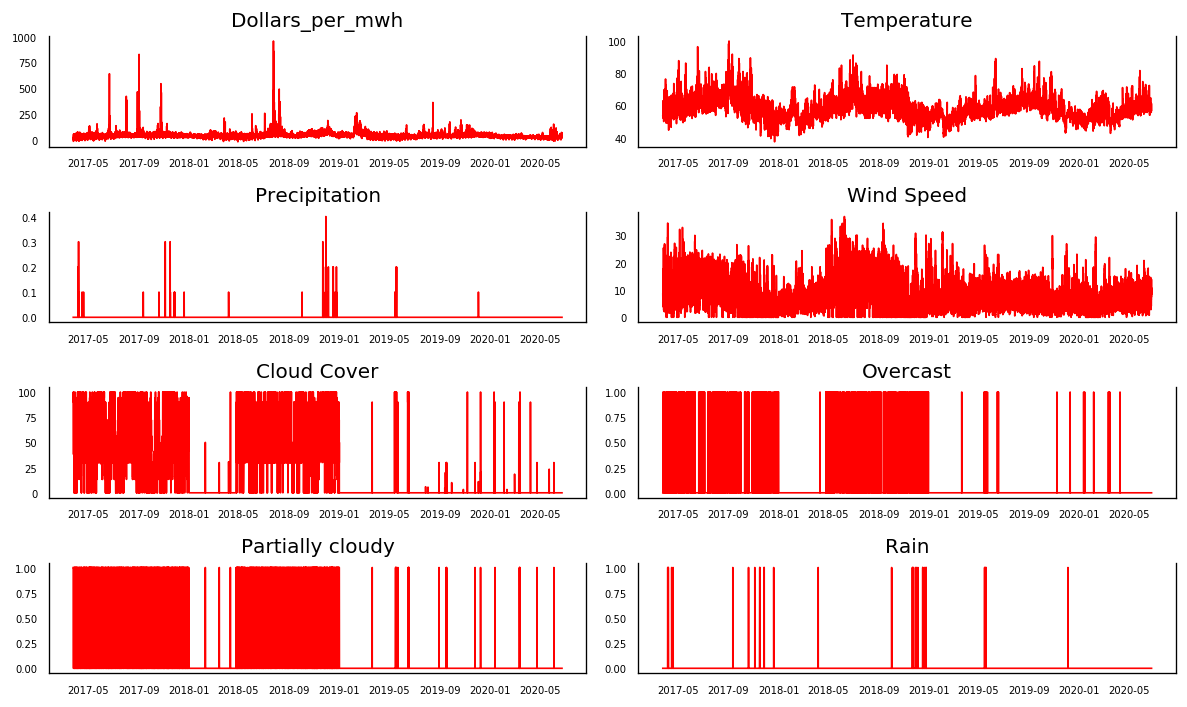

In [10]:
fig, axes = plt.subplots(nrows=4, ncols=2, dpi=120, figsize=(10,6))   #visualizing the line plot of each column
for i, ax in enumerate(axes.flatten()):                 #this and the next few blocks of code are from Sarit Maitra
    data = df3[df3.columns[i]]                  #https://towardsdatascience.com/granger-causality-and-vector-auto-regressive-model-for-time-series-forecasting-3226a64889a6
    ax.plot(data, color='red', linewidth=1)
    ax.set_title(df3.columns[i])
    ax.xaxis.set_ticks_position('none')       #I seperated this notebook from my main notebook because this is for
    ax.yaxis.set_ticks_position('none')       #a multivariate time series, whereas I have a univariate time series
    ax.spines['top'].set_alpha(0)             # with exogenous variables
    ax.tick_params(labelsize=6)
plt.tight_layout()

In [11]:
for i in df3.columns:                                     # testing each column to see if it's a normal distribution
                                                          # #this is more for multivariate time series
    stat,p = stats.normaltest(df3[i])
    print(i)
    print("Statistics = %.3f, p=%.3f" % (stat,p))
    alpha = 0.05
    if p> alpha:
        print(f"{i} Data looks Gaussian (fail to reject null hypothesis)")
    else:
        print(f"{i} Data looks non-Gaussian (reject null hypothesis)")

        

Dollars_per_mwh
Statistics = 44327.141, p=0.000
Dollars_per_mwh Data looks non-Gaussian (reject null hypothesis)
Temperature
Statistics = 3312.498, p=0.000
Temperature Data looks non-Gaussian (reject null hypothesis)
Precipitation
Statistics = 70344.717, p=0.000
Precipitation Data looks non-Gaussian (reject null hypothesis)
Wind Speed
Statistics = 4154.024, p=0.000
Wind Speed Data looks non-Gaussian (reject null hypothesis)
Cloud Cover
Statistics = 4434.465, p=0.000
Cloud Cover Data looks non-Gaussian (reject null hypothesis)
Overcast
Statistics = 9508.279, p=0.000
Overcast Data looks non-Gaussian (reject null hypothesis)
Partially cloudy
Statistics = 5175.595, p=0.000
Partially cloudy Data looks non-Gaussian (reject null hypothesis)
Rain
Statistics = 60518.762, p=0.000
Rain Data looks non-Gaussian (reject null hypothesis)


In [12]:
for i in df3.columns:                   #this is more for multivariate time series
    print(i)                            #checking each column's kurtosis and skewness
    print(f'Kurtosis of normal distribution: {stats.kurtosis(df3[i])}')
    print(f'Skewness of normal distribution: {stats.skew(df3[i])}')

Dollars_per_mwh
Kurtosis of normal distribution: 202.63519669362333
Skewness of normal distribution: 9.670315486504757
Temperature
Kurtosis of normal distribution: 1.5143258589460258
Skewness of normal distribution: 0.7964612345978433
Precipitation
Kurtosis of normal distribution: 865.2652201811093
Skewness of normal distribution: 26.814847046428714
Wind Speed
Kurtosis of normal distribution: 0.967620577472363
Skewness of normal distribution: 1.0509479180767038
Cloud Cover
Kurtosis of normal distribution: -0.0551987111833645
Skewness of normal distribution: 1.207752973178721
Overcast
Kurtosis of normal distribution: 1.8959239523041713
Skewness of normal distribution: 1.9738095025366995
Partially cloudy
Kurtosis of normal distribution: -0.20095320751375922
Skewness of normal distribution: 1.34128549999105
Rain
Kurtosis of normal distribution: 364.66505017158477
Skewness of normal distribution: 19.148499945729036


'Dollars_per_mwh', 'Precipitation' and 'Rain' have more kurtosis than the normal distribution. Their data is more concentrated about the mean. Their curves are Leptokurtic. The remaing columns are very close to normal distributions.

All of the columns have positive skewness.

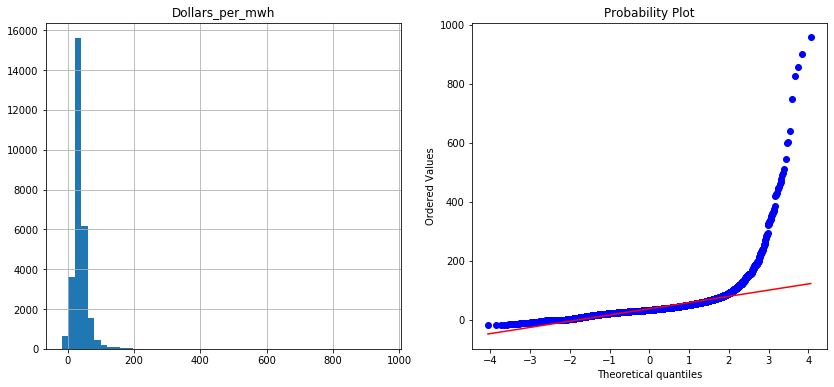

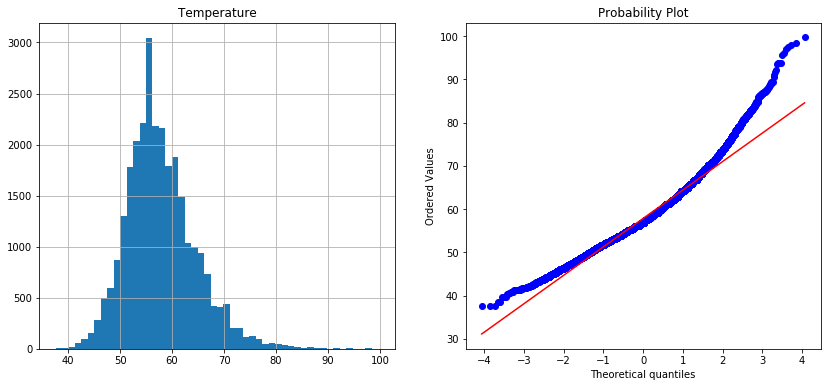

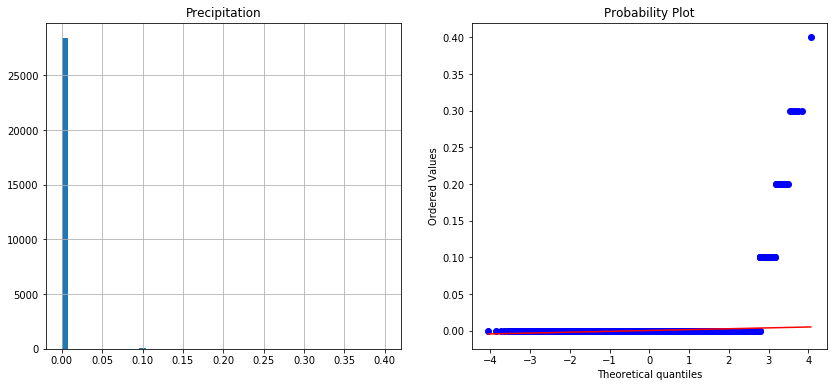

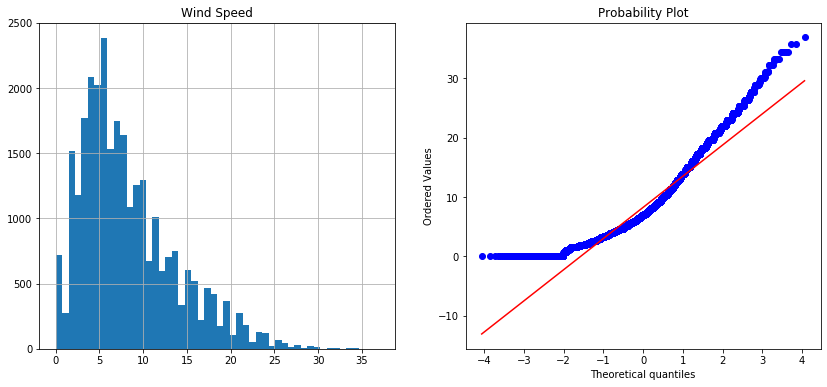

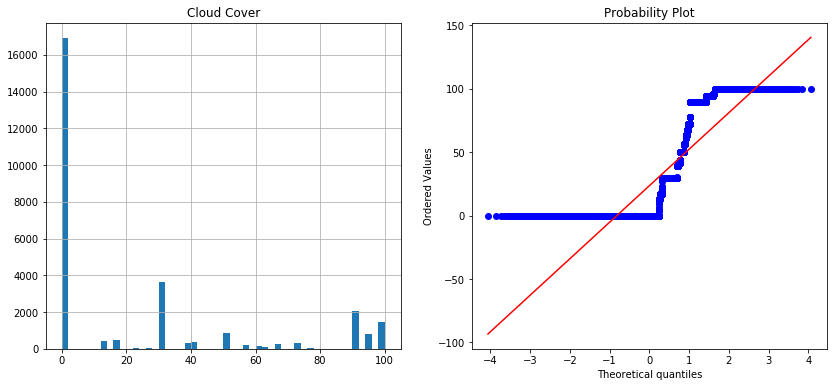

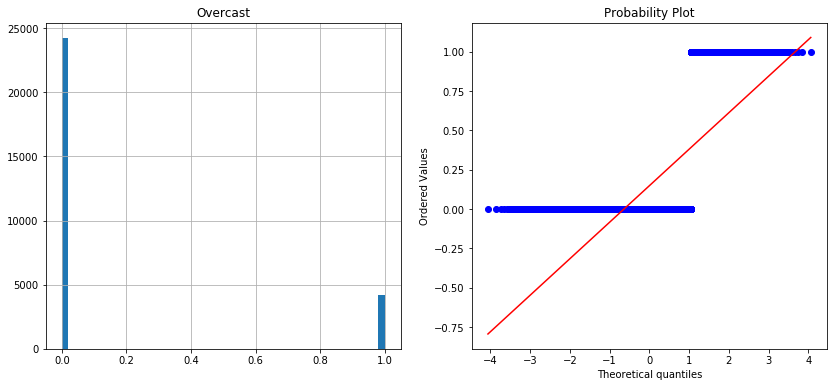

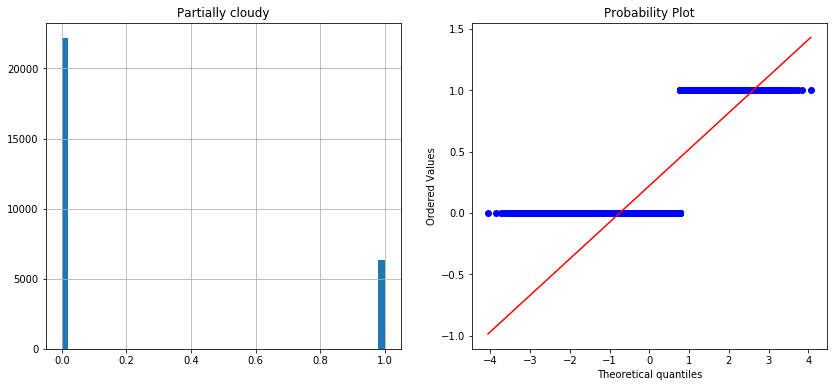

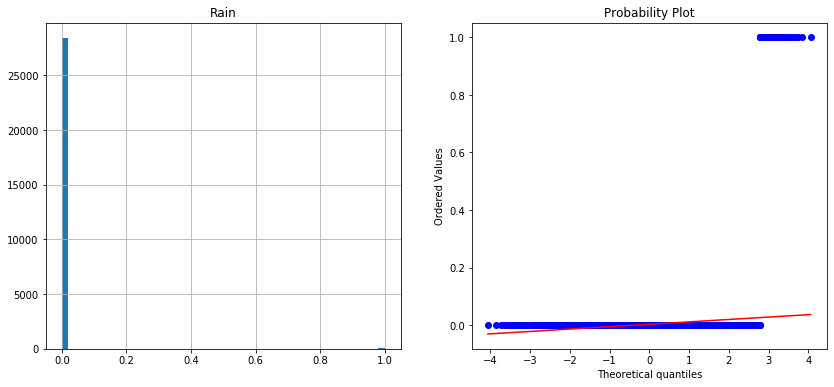

In [13]:
for i in df3.columns:                          #this is more for multivariate time series
    plt.figure(figsize=(14,6))                 #histogram and probability plot of each column
    plt.subplot(1,2,1)
    df3[i].hist(bins=50)
    plt.title(i)
    plt.subplot(1,2,2)
    stats.probplot(df3[i], plot=plt);
    df3[i].describe().T

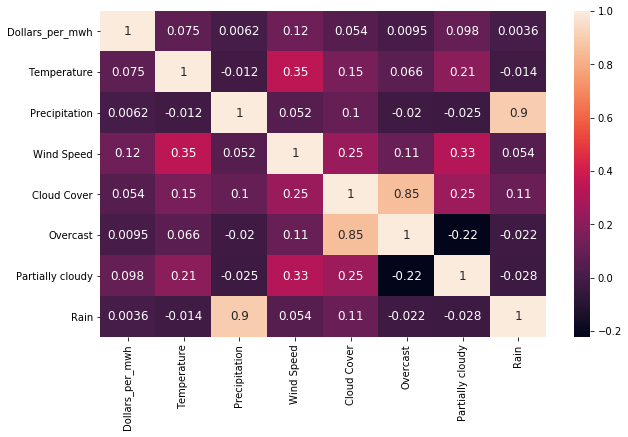

In [14]:
corr = df3.corr()
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, annot=True, annot_kws={'size':12})
heat_map=plt.gcf()
heat_map.set_size_inches(10,6)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()                                     #this is more for multivariate time series

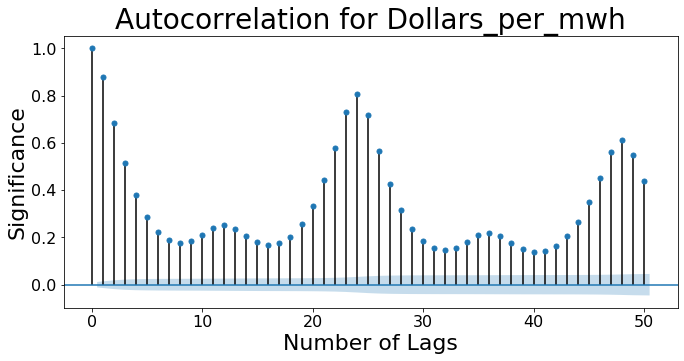

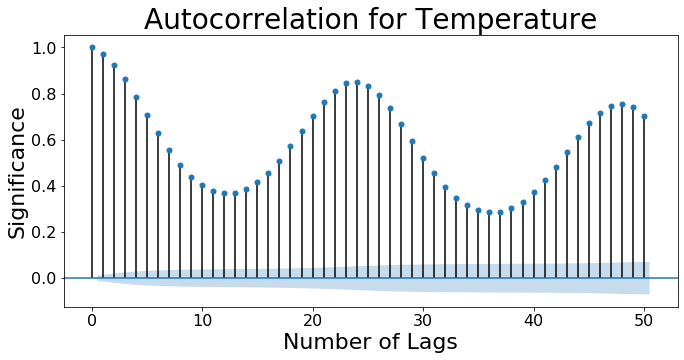

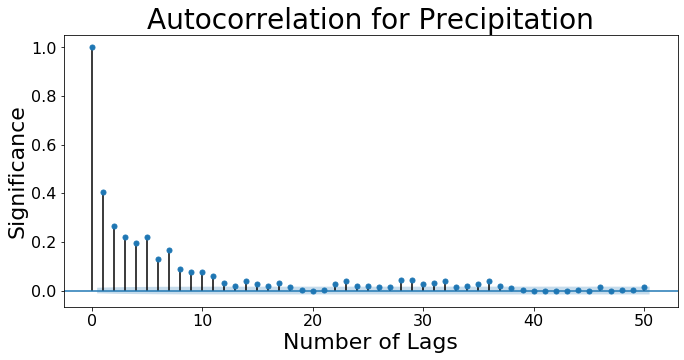

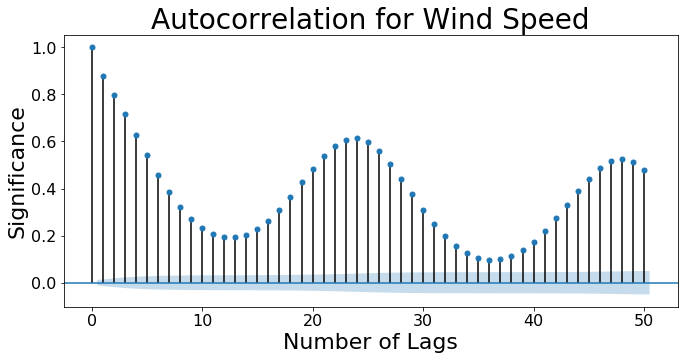

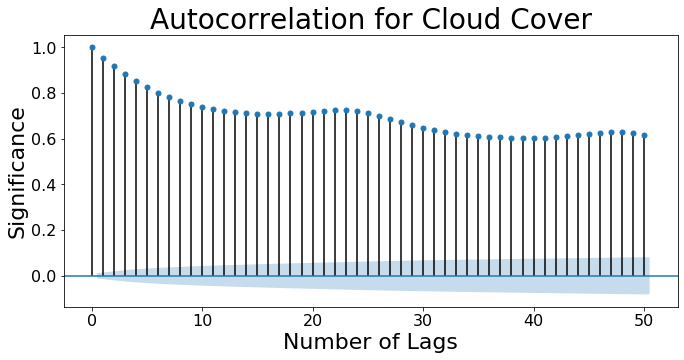

KeyError: 'Overcast'

In [18]:
from statsmodels.graphics.tsaplots import plot_acf                  #this is more for multivariate time series
from matplotlib.pylab import rcParams                             

for i in df3:           
    rcParams['figure.figsize'] = 11, 5   
    plot_acf(df[i], lags=50)
    plt.xlabel('Number of Lags', fontsize=22)
    plt.ylabel('Significance', fontsize=22)
    plt.tick_params(axis='both', labelsize=16)
    plt.title(f'Autocorrelation for {i}',fontsize=28)
    plt.show()

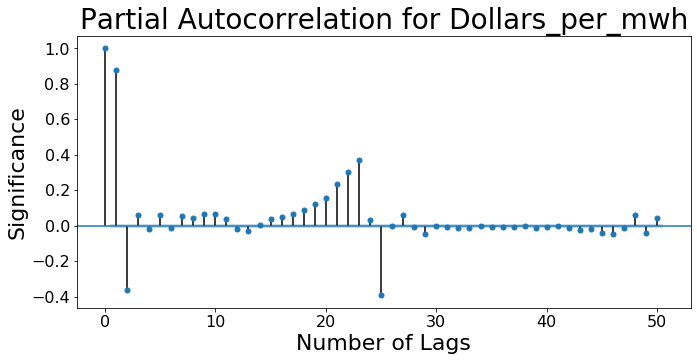

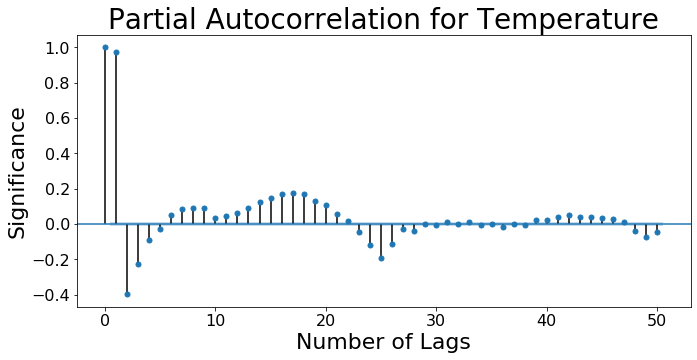

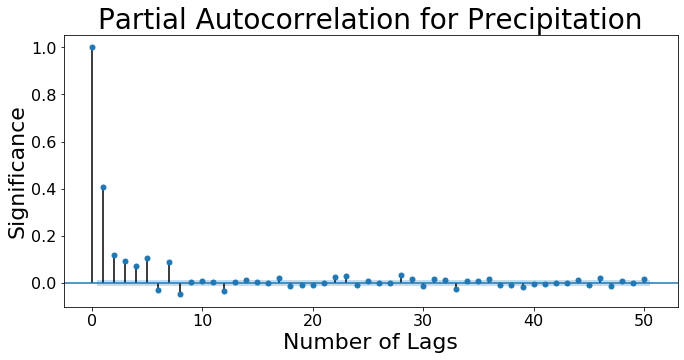

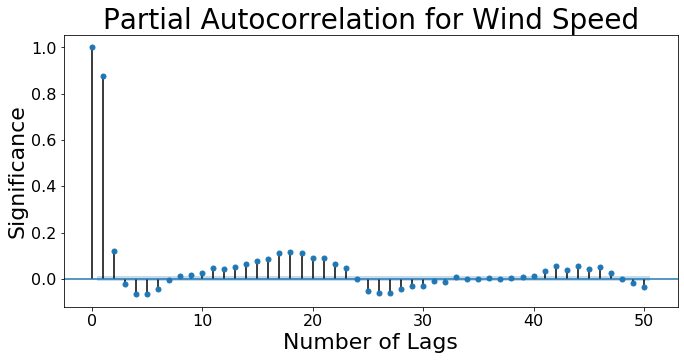

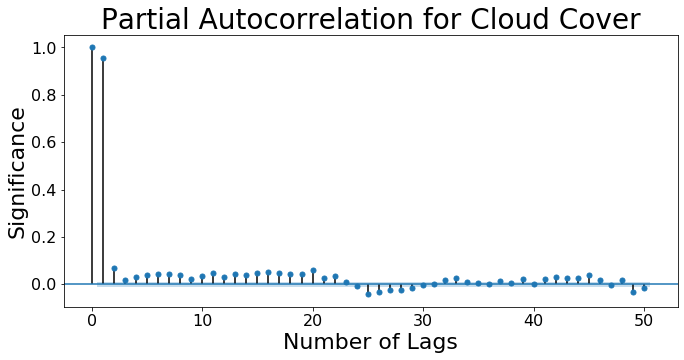

KeyError: 'Overcast'

In [19]:
from statsmodels.graphics.tsaplots import plot_pacf                 #this is more for multivariate time series
from matplotlib.pylab import rcParams 

for i in df3:           
    rcParams['figure.figsize'] = 11, 5   
    plot_pacf(df[i], lags=50)
    plt.xlabel('Number of Lags', fontsize=22)
    plt.ylabel('Significance', fontsize=22)
    plt.tick_params(axis='both', labelsize=16)
    plt.title(f'Partial Autocorrelation for {i}', fontsize=28)
    plt.show()